In [28]:
# Authors: Jeroen BUil
# License: BSD-3-Clause

# 2. Build XGBoost Models

### About:
This notebook does:
- Feature Extraction:
    - Further processing of the data to get it in a format ready for model training
- Modeling:
    - Build CNN model => high performing! =)
    - (Experimental) Build a XGB model => low performce
    - (Exploratory) PCA + tSNE feature exploration to explore low performance of XGB


## Prequisistes
1_Exploratory_Data_Analysis notebook must be run before working on **
Essential file(s) are created in the subsequent steps.

# Init

In [39]:
import os
import sys
import glob as glob

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from tqdm.notebook import tqdm

from IPython.display import clear_output
from PIL import Image, ImageChops
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

# Force add module to sys path as it is sometimes not recognised
module_path = os.path.abspath(os.path.join("..")) + "/deegtal_coding_task"
if module_path not in sys.path:
    sys.path.append(module_path)
from config import *
from dimensionality_reduction import (
    get_tsne_df,
    plot_dim_reduction,
    get_pca_df,
)
from model_architecture import SimpleCNN

# Load preprocessed EEG recordings

In [31]:
preprocessed_eeg_dict_file = "preprocessed_eeg_dict.pkl"
preprocessed_eeg_dict_file_path = INTERIM_DATA_DIR / preprocessed_eeg_dict_file


if Path.exists(preprocessed_eeg_dict_file_path):
    print("Loading preprocessed_eeg_dict")
    with open(preprocessed_eeg_dict_file_path, "rb") as pkl_rb_obj:
        preprocessed_eeg_dict = pickle.load(pkl_rb_obj)
else:
    ValueError("No file found at the following path: {preprocessed_eeg_dict_file_path}")

print("Done")

Loading preprocessed_eeg_dict
Done


In [32]:
recording = preprocessed_eeg_dict[0]
recording["raw"]

<RawEDF | 1_1.edf, 30 x 356250 (1425.0 s), ~81.6 MB, data loaded>

# Generate Features

The following cell further processes each preprocessed EEG recording and extracts features from them:
The features are the images of the spectogram of the selected channels (no still 1 channel)

In [33]:
# User parameters: (recommended to leave default)
recording_start = 10 * 60  # [s] start 10 min in the recording to avoid startup noise
recording_end = 15 * 60  # [s] end 15 min in the recording to avoid end recording noise
win_len = 10  # [s] window length
stepsize = 4  # [s] how far each window is spaced apart. Note: if stepsize < win_len, then there is overlap between the windows!

n_windows = int(
    np.floor((((recording_end - recording_start) - win_len) / stepsize))
)  # the maximum amount of windows that can be fitted in the recordingstart-end period
n_channels = 1  # len(mne.pick_types(raw.info, eeg=True, exclude='bads')) # currently

# Create an empty DataFrame with the required columns
df = pd.DataFrame(columns=["Group", "Recording", "Snippet"])
n_recordings = len(preprocessed_eeg_dict)

# Initialize an empty list to store dictionaries for each row
dict_list = []
mne.set_log_level("WARNING")

df_file_name = "df_feature_1_channels_5min.pkl"
df_file_path = INTERIM_DATA_DIR / df_file_name


if Path.exists(df_file_path):
    print("Loading df from storage")
    df = pd.read_pickle(df_file_path)
else:
    for iRecord in tqdm(range(n_recordings), desc=" Recording", position=tqdm._get_free_pos()):
        recording = preprocessed_eeg_dict[iRecord]
        raw = recording["raw"].copy()
        Fs = raw.info["sfreq"]

        # Crop windows of data somewhere in the middle of the recording to avoid recording start and end noise
        raw.crop(recording_start, recording_end)
        for iWindow in range(n_windows):
            # print(f"iRecord: {iRecord}, iWindow: {iWindow}")
            # Loop over recording and cut segements out of it with overlap
            window_start = iWindow * stepsize
            window_end = window_start + win_len
            window_copy = raw.copy().crop(window_start, window_end)

            # Copy data channels and time vector
            picks = mne.pick_types(window_copy.info, eeg=True, exclude="bads")
            data, times = window_copy[picks, :]

            # Loop over channels to calc spectogram for each
            spectogram_list = []  # store spectograms in here

            for iChannel in range(data.shape[0]):
                x = data[iChannel]
                # Create spectogram
                spectogram, freqs, t, im = plt.specgram(x, Fs=Fs)
                # Store in list
                spectogram_list.append(spectogram)

            # Store spectogoram + metadata as dataframe row
            # Step 1: Flatten each spectrogram
            flattened_spectrograms = [spectrogram.flatten() for spectrogram in spectogram_list]

            # Step 2: Concatenate all flattened arrays into a single 1D array
            concatenated_spectrogram = np.concatenate(flattened_spectrograms)

            # Step 3: Create dictionary and add metadata
            row_dict = {
                "Group": str(recording["Group"]),
                "Recording": str(recording["Recording"]),
                "Window": str(iWindow),
            }
            # "Spectogram": im,

            # Step 4: Add the flattened array values to the dictionary
            for idx, val in enumerate(concatenated_spectrogram):
                row_dict[f"Feature_{idx}"] = val

            # Step 5: Append the dictionary to the list
            dict_list.append(row_dict)

    # Convert the list of dictionaries into a DataFrame
    print("Converting to df")
    df = pd.DataFrame(dict_list)
    print("Saving to df")
    df.to_pickle(df_file_path)

print("Done")
# print(df.shape)

# df.head(2)

# XGBoost

In [82]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

data = df.copy().drop(["Group", "Recording", "Window"], axis=1)
label = df[["Group"]].astype(float)

# Extract feature and target arrays
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=False)

In [48]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 2
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
)

NameError: name 'xgb' is not defined

In [89]:
from sklearn.metrics import root_mean_squared_error

y_preds = model.predict(dtest_reg)
rmse = root_mean_squared_error(y_test, y_preds)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.321


In [101]:
params = {"objective": "reg:squarederror"}
n = 100

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,
    # Activate early stopping
    early_stopping_rounds=10,
)

y_preds = model.predict(dtest_reg)
rmse = root_mean_squared_error(y_test, y_preds)
print(f"RMSE of the base model: {rmse:.3f}")

[0]	train-rmse:0.35178	validation-rmse:0.39266
[10]	train-rmse:0.01227	validation-rmse:0.20104
[20]	train-rmse:0.00153	validation-rmse:0.19891
[30]	train-rmse:0.00042	validation-rmse:0.19866
[40]	train-rmse:0.00023	validation-rmse:0.19865
RMSE of the base model: 0.199


In [127]:
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    precision_recall_curve,
)
import itertools


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def show_data(cm, print_res=0):
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tn = cm[0, 0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    if print_res == 1:
        print("Precision =     {:.3f}".format(precision))
        print("Recall =  {:.3f}".format(recall))
        print("F1 = {:.3e}".format(f1))
    return precision, recall, f1

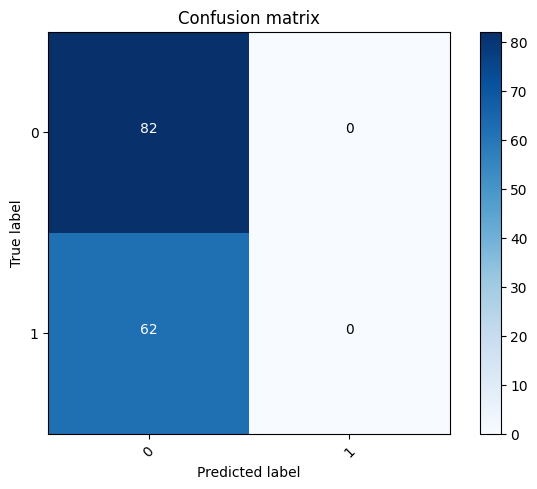

Precision =     nan
Recall =  0.000
F1 = nan


C:\Users\buil003\AppData\Local\Temp\ipykernel_21100\510456047.py:38: RuntimeWarning:

invalid value encountered in scalar divide



In [128]:
thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    cm,
    ["0", "1"],
)
precision, recall, f1 = show_data(cm, print_res=1)

In [103]:
def plot_roc(X_, y_, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_, y_, par)
        ax1.plot(mean_fpr, mean_tpr, label=name_par + " = " + str(l))
        ax2.plot(mean_rec, mean_prec, label=name_par + " = " + str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color="b", linestyle="dashed", linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel("FPR/Fallout")
    ax1.set_ylabel("TPR/Recall")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax1.set_title("ROC")
    ax2.set_title("PR")
    ax2.legend(loc="lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

<Axes: title={'center': 'Feature Importance'}>

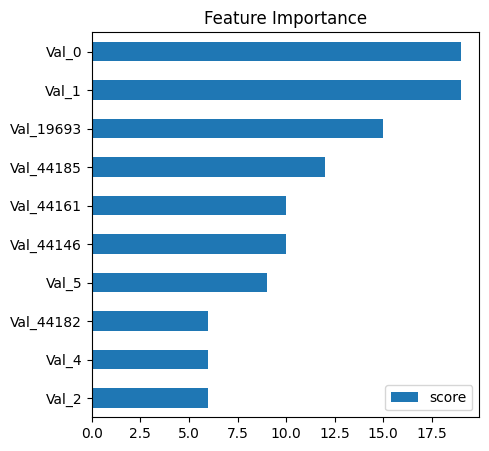

In [114]:
feature_important = model.get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

df_feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"])
df_feature_importance.nlargest(10, columns="score").sort_values(by="score", ascending=True).plot(
    kind="barh", figsize=(5, 5), title="Feature Importance"
)  ## plot top 40 features

# Dimensionality Reduction

# tSNE

In [61]:
labels = ["Group", "Recording"]

df_tsne, tsne_embedding = get_tsne_df(
    df=df_groupby,
    labels=labels,
    perplexity=2,
)

plot_dim_reduction(
    df=df_tsne,
    labels=labels,
    hue_col="Group",
    title="tSNE plot",
)

In [62]:
labels = ["Group", "Recording", "Window"]

df_tsne, tsne_embedding = get_tsne_df(
    df=df,
    labels=labels,
    perplexity=30,
)

plot_dim_reduction(
    df=df_tsne,
    labels=labels,
    hue_col="Group",
    title="tSNE plot",
)

KeyboardInterrupt: 

In [ ]:
df_temp = df_tsne.copy()
df_temp["Label"] = df_temp["Group"].astype("str") + "-" + df_temp["Recording"].astype("str")

plot_dim_reduction(
    df=df_temp, labels=labels, hue_col="Label", title="tSNE plot", plot_ellips=False
)

In [64]:
labels = ["Group", "Recording", "Window"]

df_pca, pca_embedding = get_pca_df(
    df=df,
    labels=labels,
)

plot_dim_reduction(
    df=df_pca,
    labels=labels,
    hue_col="Group",
    title="PCA plot",
)